In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import joblib

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, make_scorer)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Descripción de las Columnas del Dataset

| **Columna**               | **Descripción** |
|---------------------------|----------------|
| `Applicant_ID`            | Identificador único de cada solicitante. |
| `Applicant_Gender`        | Género del solicitante (`M` para masculino, `F` para femenino). |
| `Owned_Car`              | Indica si el solicitante posee un coche (`1` para sí, `0` para no). |
| `Owned_Realty`           | Indica si el solicitante posee una propiedad inmobiliaria (`1` para sí, `0` para no). |
| `Total_Children`         | Número total de hijos del solicitante. |
| `Total_Income`           | Ingreso total anual del solicitante. |
| `Income_Type`            | Tipo de fuente de ingresos del solicitante (por ejemplo, "Working", "State Servant", "Commercial associate"). |
| `Education_Type`         | Nivel de educación del solicitante (por ejemplo, "Higher education", "Secondary education"). |
| `Family_Status`          | Estado civil del solicitante (por ejemplo, "Married", "Single", "Widow"). |
| `Housing_Type`           | Tipo de vivienda en la que reside el solicitante (por ejemplo, "House / apartment", "Municipal apartment"). |
| `Owned_Mobile_Phone`     | Indica si el solicitante posee un teléfono móvil (`1` para sí, `0` para no). |
| `Owned_Work_Phone`       | Indica si el solicitante posee un teléfono de trabajo (`1` para sí, `0` para no). |
| `Owned_Phone`            | Indica si el solicitante posee otro teléfono adicional (`1` para sí, `0` para no). |
| `Owned_Email`            | Indica si el solicitante posee un correo electrónico (`1` para sí, `0` para no). |
| `Job_Title`              | Cargo o título profesional del solicitante (por ejemplo, "Accountants", "Laborers", "Managers"). |
| `Total_Family_Members`   | Número total de miembros en la familia del solicitante. |
| `Applicant_Age`          | Edad del solicitante en años. |
| `Years_of_Working`       | Años de experiencia laboral del solicitante. |
| `Total_Bad_Debt`         | Cantidad total de deudas incobrables del solicitante. |
| `Total_Good_Debt`        | Cantidad total de deudas bien gestionadas del solicitante. |
| `Status`                 | Estado del solicitante (`1` para aprobado, `0` para rechazado). |

# 2. División en train y test

In [2]:
df = pd.read_csv("../data/Application_Data.csv")

In [3]:
target = "Status"

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), 
                                                    df[target],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df[target])

In [5]:
# Combinar X_train e y_train
train_df = X_train.copy()
train_df[target] = y_train

# Combinar X_test e y_test
test_df = X_test.copy()
test_df[target] = y_test

# Exportar a CSV
train_df.to_csv("../data/Application_Data_train2.csv", index=False)
test_df.to_csv("../data/Application_Data_test2.csv", index=False)

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20102, 20)
(20102,)
(5026, 20)
(5026,)


### Pipeline

In [7]:
# ======================= FUNCIONES ========================
def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    return df

# ======================= CARGA DE DATOS ========================
train_path = "../data/Application_Data_train2.csv"
test_path = "../data/Application_Data_test2.csv"
target = "Status"

train = load_data(train_path)
test = load_data(test_path)

X_train = train.drop(columns=target)
y_train = train[target]

# ======================= DEFINIR COLUMNAS ========================
num_features = [
    "Applicant_Age", "Years_of_Working", "Total_Bad_Debt",
    "Total_Good_Debt", "Total_Children", "Total_Family_Members"
]

cat_features = [
    "Applicant_Gender", "Income_Type", "Education_Type",
    "Family_Status", "Housing_Type", "Job_Title"
]

columns_to_exclude = ["Applicant_ID", "Owned_Mobile_Phone"]

# ======================= PIPELINES ========================
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features),
    ("drop", "drop", columns_to_exclude)
], remainder="passthrough")

# ======================= MODELOS CON PIPELINE ========================
logistic_pipeline = Pipeline([
    ("Preprocesado", preprocessing),
    ("Modelo", LogisticRegression(solver='liblinear', random_state=42))
])

random_pipeline = Pipeline([
    ("Preprocesado", preprocessing),
    ("Modelo", RandomForestClassifier(class_weight="balanced", random_state=42))
])

xgb_pipeline = Pipeline([
    ("Preprocesado", preprocessing),
    ("Modelo", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [8]:
# ======================= METRICA ========================
balanced_scorer = "balanced_accuracy"

# ======================= GRIDSEARCHCV ========================
reg_log_param = {
    "Modelo__penalty": ["l1", "l2"],
    "Modelo__C": np.logspace(0, 4, 10)
}

rand_forest_param = {
    'Modelo__n_estimators': [100, 200],
    'Modelo__max_depth': [4, 8, None],
    'Modelo__max_features': [2, 3, "sqrt"]
}

xgb_param = {
    'Modelo__n_estimators': [100, 200],
    'Modelo__max_depth': [3, 5],
    'Modelo__learning_rate': [0.1, 0.3]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_reg_log = GridSearchCV(logistic_pipeline, reg_log_param, cv=cv, scoring=balanced_scorer, verbose=1, n_jobs=-1)
gs_rand_forest = GridSearchCV(random_pipeline, rand_forest_param, cv=cv, scoring=balanced_scorer, verbose=1, n_jobs=-1)
gs_xgb = GridSearchCV(xgb_pipeline, xgb_param, cv=cv, scoring=balanced_scorer, verbose=1, n_jobs=-1)

grids = {
    "LogReg": gs_reg_log,
    "RandomForest": gs_rand_forest,
    "XGBoost": gs_xgb
}

In [9]:
# ======================= ENTRENAMIENTO ========================
for name, grid in grids.items():
    print(f"\nEntrenando {name}...")
    grid.fit(X_train, y_train)


Entrenando LogReg...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Entrenando RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Entrenando XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [10]:
# ======================= RESULTADOS ========================
results = [(name, model.best_score_, model.best_params_) for name, model in grids.items()]
results_df = pd.DataFrame(results, columns=["Model", "Best Balanced Accuracy", "Best Params"]).sort_values(by="Best Balanced Accuracy", ascending=False)
print("\n📊 Resultados finales:")
results_df


📊 Resultados finales:


,Model,Best Balanced Accuracy,Best Params
2,XGBoost,0.979687,"{'Modelo__learning_rate': 0.3, 'Modelo__max_de..."
1,RandomForest,0.968651,"{'Modelo__max_depth': 4, 'Modelo__max_features..."
0,LogReg,0.928897,"{'Modelo__C': 59.94842503189409, 'Modelo__pena..."


In [12]:
# ======================= GUARDAR MEJOR MODELO ========================
best_model_name = results_df.iloc[0]["Model"]
best_model = grids[best_model_name]

with open('modelo_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)

joblib.dump(best_model, 'modelo_pipeline.joblib')

['modelo_pipeline.joblib']


🔍 Evaluación del Mejor Modelo:
Accuracy en test: 0.9994

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       1.00      1.00      1.00      5002

    accuracy                           1.00      5026
   macro avg       0.98      0.96      0.97      5026
weighted avg       1.00      1.00      1.00      5026



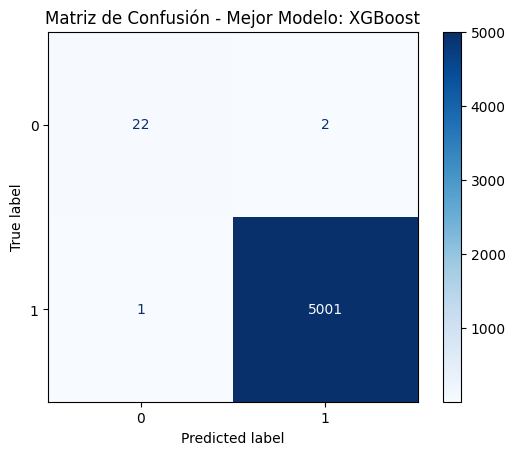

In [16]:
# Predicción
y_pred = best_model.predict(X_test)

# Accuracy y classification report
print("\n🔍 Evaluación del Mejor Modelo:")
print(f"Accuracy en test: {accuracy_score(y_test, y_pred):.4f}\n")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# Crear y mostrar la matriz de confusión con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_estimator(
    best_model,             # Estimador entrenado
    X_test, 
    y_test, 
    display_labels=[0,1],   # Ajustar según tus clases
    cmap="Blues",           # Ajustar el mapa de color si deseas
    values_format="d"       # Formato de los valores
)

plt.title(f"Matriz de Confusión - Mejor Modelo: {best_model_name}")
plt.show()

In [15]:
best_model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('Preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Applicant_Age',
                                                                          'Years_of_Working',
                                                                          'Total_Bad_Debt',
                                                                          'Total_Good_Debt',
                                                                          'Total_Children',
                                                                          'Total_Fam...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'Modelo__learning_rate': [0.1, 0.3],
                         'Modelo__max_depth': [3, 5],
                         'Modelo__n_estimators': [100, 200]},
             scoring='balanced_accuracy', verbose=1)